In [15]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import neurokit2 as nk
import pandas as pd
import os
import torch
import numpy as np

import config

In [16]:
# load train-samples-overview file
overview_file = os.path.join(config.OUT_FOLDER, 'train_df.csv')
overview_df = pd.read_csv(overview_file)
one_sample_in_s = (config.SAMPLING_RATE/1000)
time_left = 300 # in ms
time_right = 500 # in ms
samples_left = int(time_left*one_sample_in_s)
samples_right = int(time_right*one_sample_in_s)

avg_beat_list = [] # contains for each subject another list which contains the subjects average heartbeat and age_group

for idx, row in overview_df.iterrows():
    ecg_file = os.path.join(config.OUT_FOLDER, row[config.TENSOR_FILE_COLUMN_NAME])
    ecg_signal = torch.load(ecg_file).numpy().squeeze() #load signal
    # deactivated cleaning crops since it cleans 3s-crops differently from the whole ecg, which is done for figure 7 in the paper
    ecg_signal_cleaned = ecg_signal#nk.ecg_clean(ecg_signal, sampling_rate=config.SAMPLING_RATE)
    # get R-peak positions
    _, crop_peaks = nk.ecg_peaks(ecg_signal_cleaned, sampling_rate=config.SAMPLING_RATE)
    peaks_raw = crop_peaks["ECG_R_Peaks"]
    beat_parts = []
    # crop left and right of each R-peak
    for r_peak_sample in peaks_raw:
        if (r_peak_sample - samples_left > 0) and (r_peak_sample + samples_right < len(ecg_signal_cleaned)):
            beat_parts.append(ecg_signal_cleaned[(r_peak_sample - samples_left):(r_peak_sample + samples_right)])
    # get the average heartbeat for this subject and save it
    avg_beat_list.append([sum(beat_parts)/len(beat_parts), row[config.LABEL_COLUMN_NAME]])
    if idx % 50 == 0:
        print(f"currently at {idx}/{len(overview_df)}")

currently at 0/657
currently at 50/657
currently at 100/657
currently at 150/657
currently at 200/657
currently at 250/657
currently at 300/657
currently at 350/657
currently at 400/657
currently at 450/657
currently at 500/657
currently at 550/657
currently at 600/657
currently at 650/657


In [17]:
# get mean heartbeat per class
age_group_mean_beat_list = [] # list containing the mean heartbeat of each age group
age_group_sample_std_list = [] # list containing an array per age group with the per-sample standart-deviation
age_group_sample_min_list = [] # list containing an array per age group with the per-sample 5%-percentile
age_group_sample_max_list = [] # list containing an array per age group with the per-sample 95%-percentile
for age_group in config.AGE_GROUPS:
    age_group_beat_list = []
    for avg_beat, label in avg_beat_list:
        if age_group==label:
            age_group_beat_list.append(avg_beat)
    # make matrix out of the average beats of the subjects of this age group
    one_array = np.vstack(age_group_beat_list)
    beat_matrix = one_array.reshape(len(age_group_beat_list), samples_left+samples_right) # one beat-array per row
    #age_group_mean_beat_list.append([np.mean(beat_matrix, axis=0), age_group])
    age_group_mean_beat_list.append([np.mean(beat_matrix, axis=0), age_group])
    age_group_sample_std_list.append(beat_matrix.std(0))

    age_group_sample_min_list.append(np.quantile(beat_matrix, 0.05, axis=0))
    age_group_sample_max_list.append(np.quantile(beat_matrix, 0.95, axis=0))
    if age_group % 3 == 0:
        print(f"currently at {age_group}/{config.NUM_CLASSES}")


currently at 3/15
currently at 6/15
currently at 9/15
currently at 12/15
currently at 15/15


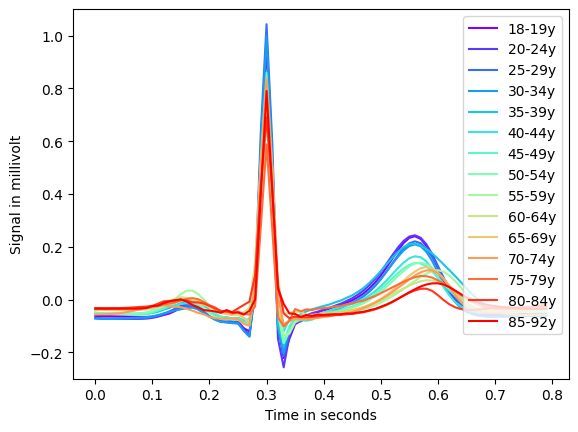

In [18]:
# plot mean heartbeat of each group superpositioned
gradient = np.linspace(0, 1, config.NUM_CLASSES)
color_list = [cm.rainbow(x) for x in gradient]
my_colors = [colors.rgb2hex(color) for color in color_list]

x = np.arange(samples_left+samples_right)*(1/one_sample_in_s)/1000 #/1000 to get from milliseconds to seconds

for idx, age_group in enumerate(config.AGE_GROUPS):
    y, _ = age_group_mean_beat_list[idx]
    plt.plot(x, y, my_colors[idx], label=f"{config.GROUP_NAMES[age_group-1]}")
plt.ylim(-0.3,1.1) # so that the scaling is the same for all plots
plt.xlabel("Time in seconds")
plt.ylabel("Signal in millivolt")
plt.legend(loc="best")
plt.show()

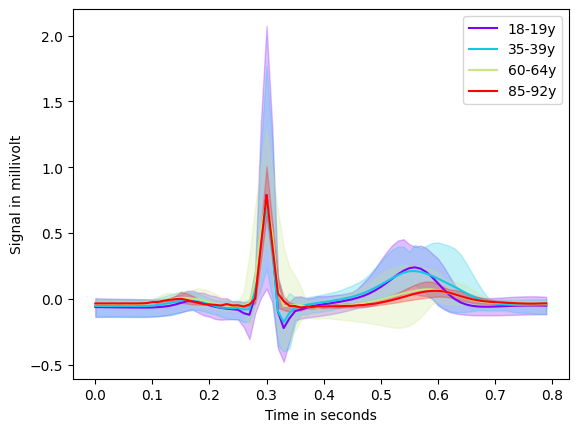

In [20]:
# show std-error-bar
# quite a mess if all are shown --> show every 5th
for cnt, age_group in enumerate([1, 5, 10, 15]):
    idx = age_group-1
    y, _ = age_group_mean_beat_list[idx]
    y_max = age_group_sample_max_list[idx]
    y_min = age_group_sample_min_list[idx]
    # plot the group-mean heartbeat again
    plt.plot(x, y, my_colors[idx], label=f"{config.GROUP_NAMES[age_group-1]}")
    std_array = age_group_sample_std_list[idx]
    # plot its 5%-95% range
    plt.fill_between(x=x, y1=y_min, y2=y_max, alpha=0.25, color=my_colors[idx])
plt.xlabel("Time in seconds")
plt.ylabel("Signal in millivolt")
plt.legend(loc="best")
plt.show()